<a href="https://colab.research.google.com/github/Sammm21/ML/blob/main/Fastailesson3(or_4_depending_on_how_you_look_at_it%2CB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training A Digit Classifier**

Install fastbook to run in colab

In [395]:
# Run to make sure fastai runs in colab
!pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()

Load a toy dataset version of MNIST with only 3's and 7's

In [396]:
path = untar_data(URLs.MNIST_SAMPLE)

Path represents a filesystem path but unlike PurePath, also offers methods to do system calls on path objects.

In [397]:
Path.Base_PATH = path

In [398]:
Path?

List the directories and folders with the data

In [399]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

Check source code and documentation with ? , ??, and doc()

In [400]:
path.ls?
path.ls??
doc(path.ls)

Check what's in the train folder

In [401]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

Assign contents of training directory i.e. 3's and 7's sorted to variables thees and sevens

In [402]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

Display what one of the threes looks like from our dataset

In [403]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Display what type it is:

In [404]:
type(im3)

PIL.PngImagePlugin.PngImageFile

In order to view the image as a number we need to convert it into a NumPy array or a PyTorch tensor.

In [405]:
array(im3)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 233,   0

In [406]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Tensor is basically a pytorch version of a numpy array. Note: PyTorch tensors can be computed on GPUs.

In [407]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Use pandas DataFrame to color-code the values using a gradient, which shows how the image is created from the pixel values with higher values being darker than lower values. 


In [408]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


### **Pixel Similarity Model**

Let's try to find the average pixel value for images of 3's and do the same for 7's then we will have 2 groups of averages that we can then compare the averages of the pixel values of new unseen images to, in order to predict whether the images are 3's or 7's.

Step one for our simple model is to get the average of pixel values for each of our two groups:

*   Create a tensor containing all of our 3s & 7s stacked  together using Python list comprehension:


In [409]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)


*Note on list comprehension: They take the following form `new_list = [f(o) for o in a_list if o > 0]`. This will return every element of `a_list` that is greater than 0, after passing it to the funtion `f`. There are 3 parts: the collection we are iterating over `(a_list)`, an optional filter `(if o > 0]`, and something to do with each element `f(o)`.*

Check to see what one of the images looks like by displaying it with the `show_image` function:

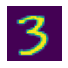

In [410]:
show_image(three_tensors[1]);

Display the shape of the tensor (it's a 28x28 image):

In [411]:
three_tensors[1].shape

torch.Size([28, 28])

Check the type of our list comprehension creation and as expected they are lists:

In [412]:
type(three_tensors)

list

In order to perform computational operations on our collection of images for our mean pixel based classifier we need to turn our list of sevens and threes into corresponing three-dimensional tensors a.k.a rank-3-tensors. 

We can do this by stacking up individual tensors in a collection into a single tensor by using the PyTorch function called `stack`. 

In [413]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

The length of a tensor's shape is its rank.

In [414]:
len(stacked_threes.shape)

3

Rank is also the number of dimensions

In [415]:
stacked_threes.ndim

3

*Note:* Member that rank is the number of axes or dimensions of a tensor; shape is a list containing the size of each axis of a tensor.

"A: Watch out because the term "dimension" is sometimes used in two ways. Consider that we live in "three-dimensonal space" where a physical position can be described by a 3-vector v. But according to PyTorch, the attribute v.ndim (which sure looks like the "number of dimensions" of v) equals one, not three! Why? Because v is a vector, which is a tensor of rank one, meaning that it has only one axis (even if that axis has a length of three). 

In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional (axis has length of 3)"; other times, it is used for the rank, or the number of axes ("a matrix has two dimensions (columns)").When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms."


Next we need to calculate what the average 3 and 7 looks like that we will be using for comparision. We do this by passing the 1st axis of our tensor to the `mean()` function, which is the axis/dimension that indexes over all the images. A.K.A for every pixel position, we will compute the average of that pixel over all of our images (so the average value of pixel 512 over all 6131 images of threes). The result will be one value for every pixel position, or a single image:


In [416]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
mean3.shape, mean7.shape, mean3.ndim

(torch.Size([28, 28]), torch.Size([28, 28]), 2)

Display our newly created mean images of 3's and 7's:


(<matplotlib.axes._subplots.AxesSubplot at 0x7f21cc5330d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f21cc540ad0>)

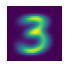

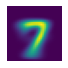

In [417]:
show_image(mean3), show_image(mean7)

Grab a sample 3 and 7 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f21cc4da110>,
 torch.Size([28, 28]))

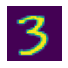

In [418]:
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]
show_image(a_3), a_3.shape

So one way to calculate how similar a particular image is to our ideal comparision average image would be to take the difference between the image and the two averages. Then the smaller the difference would indicate the more similar the image is to that average and from that we could conclude that it's more likely that image. 

However, we can't just take the difference as some differences would be negative and some positive which would skew our results. In order to solve this we can take the mean of the absolut value of the differences or the mean of the square the differences then take the square root of that value. Both these approaches would make all the values positive and are known as the l1 norm and l2 or root mean squared error norm, respectively:

* "Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes)."

* In mathematics, a norm is a function from a real or complex vector space to the nonnegative real numbers that behaves in certain ways like the distance from the origin in the case of the euclidean norm a.k.a the length of the vector.

In [419]:
dist_3_abs_l1norm = (a_3 - mean3).abs().mean()
dist_3_sqr_l2norm = ((a_3 - mean3)**2).mean().sqrt()
dist_7_abs_l1norm = (a_3 - mean7).abs().mean()
dist_7_sqr_l2norm = ((a_3 - mean7)**2).mean().sqrt()
dist_3_abs_l1norm, dist_3_sqr_l2norm, dist_7_abs_l1norm, dist_7_sqr_l2norm 

(tensor(0.1114), tensor(0.2021), tensor(0.1586), tensor(0.3021))

PyTorch provides both these approaches as loss functions found inside `torch.nn.functional`, which PyTorch recommends importing as F (and is available by default under F in fastai):


In [420]:
F.l1_loss(a_3.float(), mean3), F.mse_loss(a_3.float(), mean3), F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3.float(), mean7)

(tensor(0.1114), tensor(0.0408), tensor(0.1586), tensor(0.0913))

### **Getting Comfortable With Tensor**

"NumPy is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning.

A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, **with the innermost arrays potentially being different sizes—this is called a "jagged array."** By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. 

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. **However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged.** It is always a regularly shaped multidimensional rectangular structure.

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. 

To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs."

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to array() or tensor():


In [421]:
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [422]:
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [423]:
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

Select second row:

In [424]:
tns.shape, tns.ndim

(torch.Size([2, 3]), 2)

In [425]:
tns[1]

tensor([4, 5, 6])

Select first row

In [426]:
tns[0]

tensor([1, 2, 3])

Select all rows up to and excluding the 2nd one:

Python syntax `start:end`, `end` being excluded

In [427]:
tns[:1]

tensor([[1, 2, 3]])

Select second row


In [428]:
tns[1]

tensor([4, 5, 6])

Select all rows excluding the 1st one

In [429]:
tns[-1:]

tensor([[4, 5, 6]])

Select second column from all rows:

In [430]:
tns[:,1]

tensor([2, 5])

Select second row start at second column and end at fourth column which will be excluded, since there is no fourth column python will return columns 2 and 3 from the second row:

In [431]:
tns[1,1:3]

tensor([5, 6])

We can use standard operators on entire tensor:


In [432]:
tns + 10

tensor([[11, 12, 13],
        [14, 15, 16]])

Show tensor type as a method `.type()` as opposed to as function `type()`


In [433]:
tns.type()

'torch.LongTensor'

Tensors will automatically change from `int` to `float` if needed:

In [434]:
tns * 1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### **Computing metrics using broadcasting**

We want to calculate our metric over a validation set. This is so that we don't inadvertently overfit This is not really a risk with the pixel similarity model we're using here, since it has no trained components.

Create validation set of tensors with 3's and 7's:

In [435]:
valid_threes_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls()]).float()/255
valid_sevens_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls()]).float()/255
valid_threes_tens.shape, valid_sevens_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))


It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

Create function that calculates the l1 norm:


the -1 and -2 just signifies that it should take the mean over the last and second to last axis i.e x over the x, 28, 28 part

In [436]:
def mnist_distance(a,b): return (a - b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [437]:
valid_3_dist, valid_7_dist = mnist_distance(valid_threes_tens, mean3) , mnist_distance(valid_sevens_tens, mean3)
valid_3_dist, valid_7_dist

(tensor([0.1136, 0.1157, 0.1308,  ..., 0.1454, 0.1280, 0.1083]),
 tensor([0.1535, 0.1385, 0.1469,  ..., 0.1369, 0.1681, 0.1402]))

When Pytorch tries to perform a simple subtraction operation between two tensors of different ranks it will use broadcasting. That is, it will automatically expand the smaller tensor to have the same rank and size as the larger one. 

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

In [438]:
tensor(1,2,3) + tensor(1)

tensor([2, 3, 4])

In [439]:
test = tensor([[1,2,3],[1,2,3]])
len(test.shape), test + tensor(1)

(2, tensor([[2, 3, 4],
         [2, 3, 4]]))

We are calculating the difference between our "ideal 3" and each of the 1,010 3s and the 1028 7s in the validation set, for each of 28×28 images, resulting in the shape [1010,28,28] and [1028,28,28] respectively.

* PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
* It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).
* This is true of all broadcasting and elementwise operations and functions done in PyTorch. It's the most important technique for you to know to create efficient PyTorch code.

Next in mnist_distance we see abs. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

Finally, our function calls mean((-1,-2)). The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the last element, and -2 refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was (1010) and (1028). **In other words, for every image, we averaged the intensity of all the pixels in that image.**



In [440]:
valid_3_dist.shape, valid_7_dist.shape

(torch.Size([1010]), torch.Size([1028]))

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:


In [441]:
def is_x_3(x): return mnist_distance(x,mean3) < mnist_distance(x, mean7)


In [442]:
is_x_3(a_3), is_x_3(a_3).float(), is_x_3(valid_threes_tens), is_x_3(valid_sevens_tens)

(tensor(True),
 tensor(1.),
 tensor([True, True, True,  ..., True, True, True]),
 tensor([False, False, False,  ..., False, False, False]))

When we convert the bolean response to `float` we get 1's and 0's

In [443]:
is_x_3(valid_threes_tens).float(), is_x_3(valid_sevens_tens).float()

(tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

Calculate the accuracy of our model by taking the average of those functions for the validation set of 3s and the inverse of the 7s:

In [444]:
accuracy_3s = is_x_3(valid_threes_tens).float().mean()
accuracy_7s = (1 - is_x_3(valid_sevens_tens).float().mean())

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### **Stochastic Gradient Descent (SGD)**


Suppose we arrange for some automatic means of testing the effectiveness of any current parameter assignment in terms of actual performance and provide a mechanism for altering the parameter assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of parameter (weight) assignment, or any way of improving based on testing the effectiveness of a parameter (weight) assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

`def pr_eight(x,w): return (x*w).sum()`

Here we are assuming that x is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector w. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector w that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector w is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.)

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. **Initialize the weights.**
2. **For each image, use these weights to predict whether it appears to be a 3 or a 7.**
3. **Based on these predictions, calculate how good the model is (its loss).**
4. **Calculate the gradient, which measures for each weight, how changing that weight would change the loss.**
5. **Step (that is, change) all the weights based on that calculation.**
6. **Go back to the step 2, and repeat the process.**
7. **Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).**

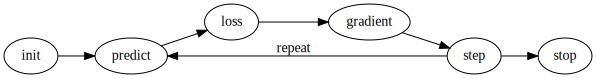

In [445]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this book. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

* **Initialize::** We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
***Loss::** This is what Samuel referred to when he spoke of testing the effectiveness of any current weight assignment in terms of actual performance. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
***Step::** A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating gradients. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
***Stop::** Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.
Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and x is a weight parameter of the function:

Before applying the above steps to our image classification problem, let's look at a simpler case. We'll start by defining a simple quadratic function which will serve as our loss function and `x` will be the weight parameter of that funciton.

In [446]:
def f(x): return x**2

Plot graph of the function:


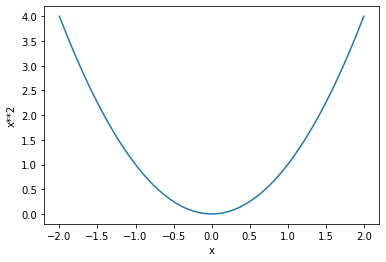

In [447]:
plot_function(f, 'x', 'x**2')

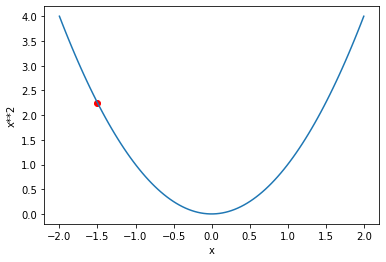

In [448]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

See what happens if you increase or decrease the parameter at a certain point aka *the adjustment* - this is simply the slope at a certain point. 

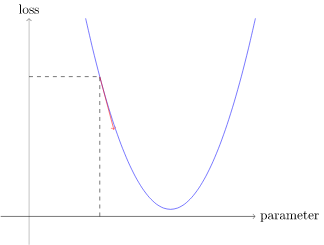

If we keep changing the weight by a little in the direction of the slope; calculating the loss and adjustment, and repeating the whole process a number of times, eventually we will reach the lowest point of the graph.

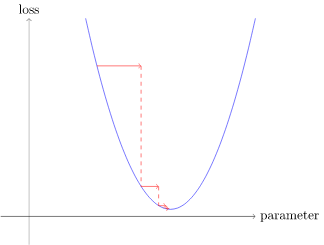


*This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change. The only minor changes are some handy ways we can make it faster, by finding better steps.*

### **Calculating Derivatives**

The gradients will tell us how much we have to change each weight to make our model better.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. **For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3.** The gradient is defined as rise/run, that is, the change in the value of the function, divided by the change in the value of the parameter. 

When we know how our function will change, then we know what we need to do to make it smaller. 

We take the partial derivaties of our function, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. 


Create tensor with the point we want to calculate the gradient of:

In [449]:
xt = tensor(3.).requires_grad_()

The special method requires_grad_() tells PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

In deep learning, "gradients" usually means the value of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of.

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [450]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

The "backward" here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer.

This is the backward pass of the network when we update the parameters by taking the partial derivates, as opposed to the "forward pass," which is where the activations are calculated.

Tell PyTorch to calculate the gradient and view them by checking the `.grad` attribute of our tensor:

In [451]:
yt.backward()
xt.grad

tensor(6.)

We can do the same for a vector of multiple values:

In [452]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

We add `.sum()` to our function so it can take a vector (rank 1 tensor) and return a scalar (rank 0 tensor)

In [453]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Calculate the gradients:

In [454]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

*The gradients only tell us the slope of the function it doesn't indicate how much we must adjust our parameters to reach the optimal value. However very large gradient indicate that we are father away from the global minimum and very small gradients the oppposite.*

### **Learning Rate**

Once we have the gradient we need to decide how big of a step we should take in the negative direction. We do this by multiplying the gradient with the learning rate (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything.Once you've picked a learning rate, you can adjust your parameters using this simple function:

w -= gradient(w) * lr

This is known as stepping your parameters, using an optimizer step.


If we pick a small LR then the algorithm will take a very long time to converge at the minima:

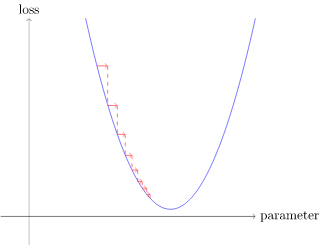

However if we pick a LR that is too large it may never converge and instead just get worse:

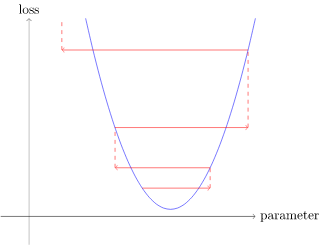

Or it may bounce around and never converge:

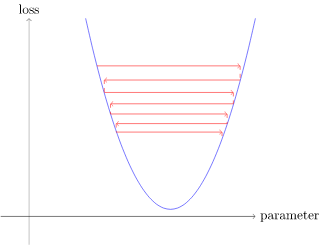

### **End-to-End SGD example**

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. We want to build a model of how the speed changes over time, measuring the speed manually every second for 20 seconds.

Create tensor for each of the 20 measurement points:

In [455]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

Since we are measuring manually it will be a little imprecise therefore we add some noise to our data that we create using a quadratic function:

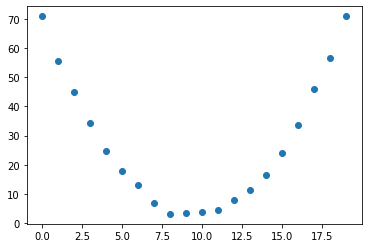

In [456]:
speed = torch.rand(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed)

Now we want to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`. (ax**2+bx+c)

We want to distinguish clearly between the functions inputs which is the time we are measuring the speed and its parameters which are the values that define which quadratic function we are trying to fit our data.

Therefore we will collect the parameters in one arguement and thus seperate the input, t, and the params in the functions signature:

In [457]:
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*time) + c

What we have done is to restrict the problem from finding the best imaginable function that fits the data to finding the best *quadratic functions* that fits our data. This makes our lives much simpler, since every quadratic function is fully defined by the three parameters a, b, and c. Therefore to find the best quadratic function we just need to find the optimal values for a, b, and c.

(We will apply this same approach for other more complex function with more parameters later such as neural nets)

In order to figure out what is the best parameters we need a loss function, which will return a value based on a prediction and a target, where lower values means the prediction is closer to the target and larger values means its farther away.

For continuous data, it's common to use *mean squared error*:

In [458]:
def mse(preds, targets): return ((preds-targets)**2).mean()

### Step 1: Initialize the Params

The first step is to initialize the parameters to some random values:

In [459]:
params = torch.randn(3).requires_grad_()

### Step 2: Calculate the predictions

Calculate predictions

In [460]:
preds = f(time, params)

Create function that shows how cloase predictions are to the targets:

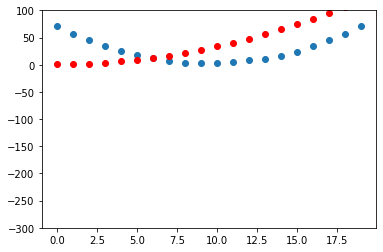

In [461]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

show_preds(preds)

### Step 3: Calculate the loss.

In [462]:
loss = mse(preds, speed)
loss

tensor(1637.0266, grad_fn=<MeanBackward0>)

In order to improve the loss we need to know the gradients.

### Step 4: Calculate the gradients

The gradients will be an approximation of how the parameters need to change:

In [463]:
loss.backward()
params.grad

tensor([10510.2930,   674.7965,    27.4423])

Use LR that we pick to 0.00001 to improve our parameters:


In [464]:
params.grad * 1e-5

tensor([0.1051, 0.0067, 0.0003])

In [465]:
params

tensor([0.3261, 0.0319, 0.6364], requires_grad=True)

### Step 5: Update the weights

`.data` makes sure PyTorch doesn't calculate the gradient of the step since we only want the gradient of our function not the step.

Update the parameters based on the gradients just calculated:

In [466]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

*Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.*

Check to see if the loss has improved:

In [467]:
preds = f(time, params)
mse(preds, speed)

tensor(841.1544, grad_fn=<MeanBackward0>)

Plot the new prediction

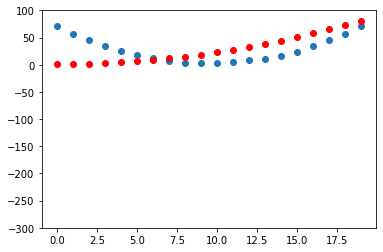

In [468]:
show_preds(preds)

We need to repeat the above steps a few times in order to get a good fit:

In [469]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds


### Step 6: Repeat the process

In [470]:
for i in range(15): apply_step(params)

841.1544189453125
690.5482177734375
662.0460815429688
656.649658203125
655.625732421875
655.4290771484375
655.3890380859375
655.3786010742188
655.373779296875
655.3701171875
655.366455078125
655.3629760742188
655.3594970703125
655.35595703125
655.3524169921875


The loss is going down. But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

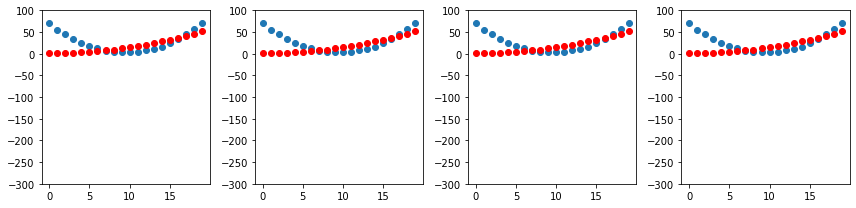

In [471]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Step 7: Stop

In this example we stop after 15 epochs arbitrarily, in practice we would base our stoppage on the training and validation losses and the metrics.

### **Summarizing Gradient Descent**

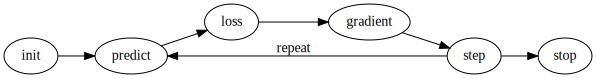

In [472]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

The first thing we did was initialize **`(init)`** the weights of our model to some random values. This is known as training from scratch, we could also take weights from a pretrained model if we were doing transfer learning. In the first case the output we will get **`(predict)`** won't look anything like the data we are trying to fit and the same is very likely if we use a pretrained model. So our model will need to learn better weights.

In order to learn better weights we need to compare the predicitons of our models with our targets (since we have labeled data we know what results the model should give), we do this comparision using a *loss function* **`(loss)`**, which returns a number that we want to be as low/small/close to zero as possible. 

We can improve our loss by improving our weights. To do this, we take a batch of data (such as images) from our training set and feed them to our model. Then we compare the corresponding targets to our output using our loss function, and the score we observe tells us how far off our prediction were, we then adjust our weights accordingly to make our predictions slightly more accurate. 

Exactly how much we should change our weights to improve our loss is done by calculating the **`(gradients)`** (partial derivatives) of the parameters of our function. We want to get to the lowest point of our loss function since that's were the loss is the smallest (global minima) we will arrive at that spot once our function that is approximating Y matches the true Y that we are trying to model, which is achieved by learning the correct/optimal weights. We can achieve this by continually taking a step in the direction of the steepest downward slope so that we should eventually arrive at that point. 

Therefore we use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically ,we multiply the gradient by a number called the *learning rate* which determines the step size **`(step)`**. Then we iterate **`(repeat)`** until we reach the minimum point, were we **`(stop)`**.


### **The MNIST loss function**

Time to create a loss function for our MNIST sample set. First we need to prep our data. Our independent variables x are the images of the 3s and 7s, which we need to concatenate into a single tensor, and also change them from a list of matrices (rank-3-tensors) into a list of vectors (rank-2-tensors). We do this using the `view` method. Which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data, B"

In [473]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need labels for our images. We'll use 1s for 3s and 0s for 7s




In [474]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

`.unsqueeze(1)` turns the vector `train_y` into a matrix by adding a unit column and we do this because PyTorch needs it to be a matrix and not a vector to do operations on it since it expects to see a matrix and not a vector.

A Dataset in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function that will take one element of `train_x` and match it with one corresponding element of `train_y`, thus when combined with `list`, provides a simple way to get this functionality:

In [475]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y, len(dset)

(torch.Size([784]), tensor([1]), 12396)

`dset[0]` is taking one row of our 12396 training rows, which contains 784 features and 1 label for each row as we can see represented by the `(x,y)` tuple we created above. 

Do the same same for the validation set

In [476]:
valid_x = torch.cat([valid_threes_tens, valid_sevens_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_threes_tens) + [0]*len(valid_sevens_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

Now it's time to go to our 7 step training process starting with randomly initializing the parameters/weights for every pixel in our input to our model: 

In [477]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [478]:
weights = init_params((28*28,1))
weights.T.shape

torch.Size([1, 784])

The function `weight*pixels` won't be flexible enough - since it will always be 0 when the pixel is 0. Therefore we add a bias term: `y=wx + b`

In [479]:
bias = init_params(1)

In neural nets, the `w` in the equation `y=wb+b` is called the weights, the `b` is called the bias. Together, the weights and bias make up the *parameters*.

We can now calculate a prediction for one image (we take the transpose of the weights matrix since for matrix multiplication to work: #rows = #columns, train_x has 784 rows and weights.T has 784 columns:

In [480]:
(train_x[0]*weights.T).sum() + bias

tensor([9.2684], grad_fn=<AddBackward0>)

There's an extremely convenient mathematical operation that calculates w*x for every row of a matrix—it's called matrix multiplication:

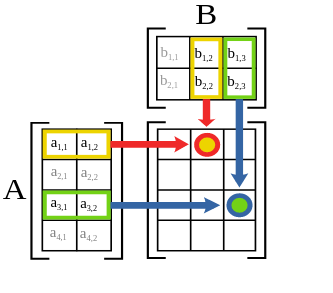

As the image above shows, matrix multiplication forms a linear combination of the rows of one matrix with the columns of another matrix and that's why number of rows has to equal number of columns for it to work. 

In python, matrix multiplication is represented with the @ operator:

In [481]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[  9.2684],
        [ -4.4898],
        [ 11.6977],
        ...,
        [-10.2290],
        [  6.5237],
        [  0.9552]], grad_fn=<AddBackward0>)

The first element is the same as we calculated above, as expected. The equation `batch@weights + bias` is one of the two fundemental equations of any neural network (the other being the *activation function*)

Let's check our accuracy. Since we labeled our 3s as 1 and 7s as 0, to decide whether output is predicted a 3 or 7 we can just check if it's greater than 0.5:

In [482]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

`.item()` unwraps the rank 0 tensor and returns a simple scalar: 

In [483]:
corrects.float().mean().item()

0.5978541374206543

Now let's see how our accuracy changes if we adjust one of our weights:

In [484]:
weights[0]

tensor([0.6386], grad_fn=<SelectBackward>)

In [485]:
with torch.no_grad():
  weights[0] *= 1.0001

In [486]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5978541374206543

As we can see above changing the weight by a small value will not actually change the accuracy at all. Therefore accuracy makes a poor loos function. If we were to use it most of the time our gradients would be zero and we would be unable to update our parameters since our step would be 0 so our predictions would remain unchanged and the model would be unable to learn.

`"In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model."`

Instead, we need a loss function that is sensitive to small changes in the weights, and that when our the change in weight results in a slightly better prediction it will give us a slightly better loss. In this case it means that if the correct answer is a 3 the score would be a little higher and if the correct answer was a 7 the score would be a little lower.

Time to create that function! 

Since the loss function doesn't receive the images themselves, but the prediction from the model. We will make one argument `prds` of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the actual true values- that is, the targets (aka labels). Therefore we make another argument `trgts`, with values of 0 or 1 which tells us whether an image us a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [487]:
trgts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])

Let's first try a loss function that measures the distance between `predictions` and `targets`:

In [488]:
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

> note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

In [489]:
#help(torch.where)

This function returns lower values when the prediction is more accurate and higher when it's less accurate:

In [490]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

`mnist_lost` will give us the mean loss and return a scalar:

In [491]:
mnist_loss(prds, trgts)

tensor(0.4333)

If we change the last prediction to be closer to correct value of 1 we can see that the loss decreases significantly:

In [492]:
mnist_loss(tensor([0.9,0.4,0.8]),trgts)

tensor(0.2333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look:


### **Sigmoid Activation Function**

The `sigmoid` function will always output a number between 0 and 1:

In [493]:
def sigmoid(x): return 1/(1 + torch.exp(-x))

In [494]:
math.e**2, torch.exp(tensor(2))

(7.3890560989306495, tensor(7.3891))

PyTorch has a accelerated version of the sigmoid function built in so we don't need to define our own and is called by `torch.sigmoid` however it's a simple function and the formula for it is specified above

(None, None)

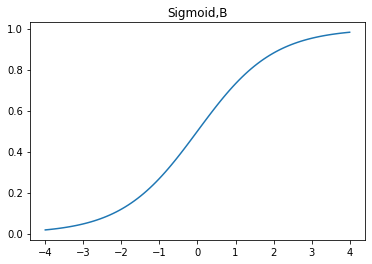

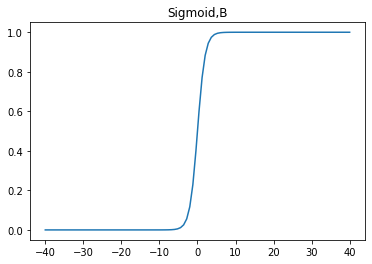

In [495]:
plot_function(torch.sigmoid, title='Sigmoid,B', min=-4, max=4), plot_function(torch.sigmoid, title='Sigmoid,B', min=-40, max=40) 

As we can see it takes any and all negative and positive inputs and smooshes their output between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to fin meaningful gradients.

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:


In [496]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

We can now rest assured that our loss function will work, even if our predictions are not between 0 and 1, the sigmoid function will make them between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence that an image is a 3, B. 

So why use a loss instead of accuract?

The key difference is that a metric is to drive human understanding for how well the model is performing while the loss is driving auromated learning. To drive automated learning, the losst must be a function that has a meaningful derivative. It can't have big flat sections and large jumps or gaps, but instead must be reasonable smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an apoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, however, are the numbers we really care about for judging the performance of our model.

### **SGD and Mini-Batches**

The next phase of the learning process is to change or update the weights based on the gradients. This is called an *optimization step*.

In order to take an optimization step we need to calculate the loss over one or more data items. If we were to calculate the loss for the whole dataset at once, and take the average that would take a very long time. If we were to calculate it for a single data item we would not use much information so it would result in a very imprecise and unstable gradient. That is we'd be going updating the weights but we would only take into account how that update would improve the model's perfomance on a single data item.

Instead a compromise is made between the two extremes: we calculate the average loss for a few data items at a time. This is called a mini-batch where the number of data items in the mini-batch is called that batch size. A larger batch size means we will get more accurate and stable estimates of our greater datasets gradients from the loss function, but would take a longer time to do the calculations and we would process fewer mini-batches per epoch. Therefore choosing the appropriate batch-size is something of an art or learned skill.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

**As we saw in our discussion of data augmentation in, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches.** PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over many batches, like so:

In [497]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 7,  4,  2,  5, 14]),
 tensor([ 8,  3,  6, 13,  1]),
 tensor([ 0, 11,  9, 12, 10])]

However for training a model, we don't just want any Python collection, we need a collection of independent and dependent variables (inputs (x), outputs (y)). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`:


In [498]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independen and dependent variables:

In [499]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 2, 17,  9, 11, 18,  8]), ('c', 'r', 'j', 'l', 's', 'i')),
 (tensor([23, 20, 14, 21,  5, 13]), ('x', 'u', 'o', 'v', 'f', 'n')),
 (tensor([24, 16, 12, 15,  6,  0]), ('y', 'q', 'm', 'p', 'g', 'a')),
 (tensor([ 1,  3,  7, 10,  4, 22]), ('b', 'd', 'h', 'k', 'e', 'w')),
 (tensor([25, 19]), ('z', 't'))]

### **Putting It All Together**

It's time to implement the following process for our mnist 3s or 7s problem: 


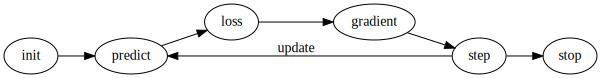

In [500]:

gv('''
init->predict->loss->gradient->step->stop
step->predict[label=update]
''')

Our process will be implemented something like this for each epoch:

```python
for x,y in dl:
  pred = model(x)
  loss = loss_func(pred, y)
  loss.backward()
  parameters -= parameters.grad * lr
```

Step 1: Reinit parameters

In [501]:
weights = init_params((28*28,1))
bias = init_params(1)

Create `DataLoader` from the `Dataset`:


In [502]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl) # first just grabs the first thing from a iterator
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Do the same for the validation set:

In [503]:
valid_dl = DataLoader(valid_dset, batch_size=256)


Create a mini-bath of 4 first rows for testing


In [504]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

Calculate the predictions:

In [505]:
preds = linear1(batch)
preds

tensor([[ -7.6214],
        [  1.9488],
        [-13.4920],
        [  0.8836]], grad_fn=<AddBackward0>)

In [506]:
linear1??

Calculate the loss:

In [507]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.6042, grad_fn=<MeanBackward0>)

Calculate the gradients:

In [508]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0130), tensor([-0.0791]))

Put it all into 1 function:

In [509]:
def calc_grad(xb,yb,model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

Test the `calc_grad` function:

In [510]:
calc_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0260), tensor([-0.1583]))

Look what happens if we call it again:

In [511]:
calc_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0390), tensor([-0.2374]))

The gradients have changed, which is a concern as you'd expect to get the same gradients for the same data! The reason for this is that `loss.backward` adds the gradient of `loss` to any gradients that are currently stored. Thus we have to set the current gradients to 0 first:

In [512]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

Methods in PyTorch whose names end in an underscore _ modify their objects *in place*. For instance, `bias.zero_` sets all elements of the tensor bias to 0.

The remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! 

If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [513]:
def train_epoch(model, lr, params):
  for xb,yb in dl: #loop through the data loader grabbing the xbatch and ybatch
    calc_grad(xb, yb, model) #calculate the gradient
    for p in params: # Go through each of the parameters
      p.data -= p.grad*lr # update each parameter (gradient descent step)
      p.grad.zero_() # zero it out for the next iteration

This is stochastic gradient descent the difference is that we use mini batches while gradient descent does it for the entire dataset.

Let's look at the accuracy of the validation set. To decide whether an output represents a 3 or a 7, we can just check whether it's greater than 0.

In [514]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [False],
        [ True]])

That give us this function to calculate the validation accuracy for:

In [515]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid() # take the sigmoid of the predictions
  correct = (preds>0.5) == yb  # compare predictions whether they're greater than 0.5 or not to tell us whether 3 or not
  return correct.float().mean() # then convert bolean to floats and take mean to get accuracy

In [516]:
batch_accuracy(linear1(batch), train_y[:4]) # take our batch put it through our linear model and calculate the accuracy

tensor(0.5000)

In [517]:
def validate_epoch(model): # Do that for every batch in the validation set
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]  #use list comprehension for the loop through all the validation set
  return round(torch.stack(accs).mean().item(), 4) # stack all the accs into a tensor and take a mean and convert it to a standard python scalar and round it

validate_epoch(linear1)

0.5137

In [518]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6836

In [519]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end='')

0.8750.93250.94820.95640.95840.96130.96470.96720.96720.96820.97010.97010.97060.97210.97260.9730.9730.9740.9750.9745

### **Creating An Optimizer**

Lets replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module. class`. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate the model from the previous section:

In [520]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [521]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [522]:
class BasicOptim:
  def __init__(self, params, lr): self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

Check what `nn.Linear` & `DataLoader` do in order to recreate it from scratch later, B:

In [523]:
nn.Linear??

In [524]:
DataLoader??

Create optimizer by passing in the model's parameters:

In [525]:
opt = BasicOptim(linear_model.parameters(), lr)

Simplify the training loop:

In [526]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

Use the same validation function as before it doesn't need to change, it's purrrfect as it is, B:

In [527]:
validate_epoch(linear_model)

0.4491

Put the training loop in a function to make things simpler:

In [528]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

Same results as in the previous section, B:

In [529]:
train_model(linear_model, 20)

0.4932 0.7031 0.8594 0.9179 0.935 0.9512 0.957 0.9633 0.9658 0.9682 0.9702 0.9712 0.9731 0.9741 0.9761 0.9765 0.9775 0.978 0.978 0.979 

Fastai provides the SGD class that, by default, does the same thing as our `BasicOptim`:

In [530]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8759 0.8174 0.9082 0.9306 0.9467 0.9546 0.9624 0.9653 0.9668 0.9692 0.9712 0.9736 0.9751 0.9761 0.9765 0.9775 0.9785 0.9785 0.979 

Fastai also provides `learner.fit`, which we can use instead of `train_model`. To create a `Learner`, we first need to create a `DataLoaders`, by passing in our training and validation `DataLoaders`:

In [531]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `cnn_learner`), we need to pass in all the elemennts that we've created in this chapter: the `DataLoaders`, the `model`, the `optimizer`, the `loss function`, and the `metrics`.

Then fit it:

In [532]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, 
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(10,lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636979,0.503384,0.495584,00:00
1,0.492786,0.205785,0.821394,00:00
2,0.182118,0.174080,0.843965,00:00
3,0.080502,0.104440,0.912169,00:00
4,0.043033,0.076925,0.933268,00:00
5,0.028389,0.061910,0.946025,00:00
6,0.022354,0.052475,0.955839,00:00
7,0.019653,0.046171,0.962709,00:00
8,0.018270,0.041736,0.965653,00:00
9,0.017430,0.038465,0.966634,00:00


### **Adding a Nonlinearity**

So far, we have a general procedure for optimizing the parameters of a function, and we've tried it out on a boring function: a simple linear classifier, which is a very constrained classifier in terms of what it can do. To make it a bit more complex (and able to handle more complex tasks), we need to add something nonlinear (i.e. different from ax + b) between two linear classifiers - this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [533]:
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res


That's it all we have in `simple_net` is two linear classifiers, B, with a `max` function between them.

Tawlmbout `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initialized randomly, just like we did in the previous section:

In [534]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params(30,1)
b2 = init_params(1)

Note that `w1` has 30 output activations, which means that `w2` needs to have 30 input activations, so they match. That means that the first layer can construct 30 different features, each representing a different mic of pixels (as we are classifying images). We can change the 30 to any number we like to make the model more or less complex. 

The function `res.max(tensor(0.0))` is called a *rectified linear unit` aka ReLU. All it does is replace every negative number with a zero:

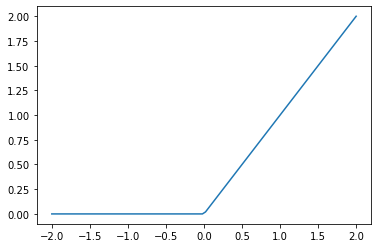

In [535]:
plot_function(F.relu)

The basic idea is that by using more linear layers we can have our model do more computations, and therefore model more and more complex functions. However we can't just stack a bunch of linear layers on top of each other because they will just be a linear combination of eachother. However by puttin a nonlinear function between them such as `max`, the layers become linearly independent from eachother. So each layer is decoupled from the other and can do its own useful work.

"*Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.*"

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [536]:
simple_net = nn.Sequential( #nn.Sequential is PyTorch function composition class
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

*`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.*

In [537]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [538]:
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.328257,0.401489,0.506869,00:00
1,0.151302,0.238074,0.791953,00:00
2,0.083189,0.118433,0.915604,00:00
3,0.054173,0.079127,0.940628,00:00
4,0.040798,0.061448,0.957311,00:00
5,0.034010,0.051614,0.962709,00:00
6,0.030136,0.045451,0.965162,00:00
7,0.027635,0.041256,0.966634,00:00
8,0.025843,0.038221,0.968106,00:00
9,0.024461,0.035914,0.969087,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in learn.recorder, with the table of output stored in the values attribute, so we can plot the accuracy over training as:

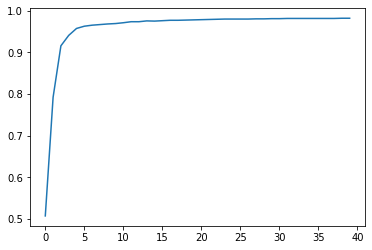

In [539]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [540]:
learn.recorder.values[-1][2]

0.981844961643219

At this point we have something that is rather cool:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

"This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes."

Grab the model:

In [541]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

### **Going Deeper**

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1,0.1)

epoch,train_loss,valid_loss,accuracy,time
